# HCAS R notebook 02: projection pursuit regression

**Author**: Eric Lehmann, CSIRO Data61  
**Date**: 11 May 2016

**Note**: this notebook can also be viewed at https://github.com/eric542/hcas

## Summary

This notebook documents the projection pursuit regression (PPR) approach to environmental space modelling. This approach is described in detail in the document _'HCAS Activity 3a(1): Environmental Space Modelling -- Review / Research Document (Methods Document)'_.

The PPR technique is a multiple regression approach where the response (RS) variable $\mathbf{y}$ is modelled as a sum of $k$ non-linearly transformed linear combinations of the predictor (ENV) variables $\mathbf{x}$:

$$ \mathbb{E}( \mathbf{y} | \mathbf{x} ) = \bar{\mathbf{y}} + \sum_{k=1}^{K} \boldsymbol{\alpha}_k \cdot g_k ( \boldsymbol{\beta}_k^T \mathbf{x} ) $$

The terms $g_k(\cdot)$ are called _ridge functions_, while the coefficients $\boldsymbol{\beta}_k$ multiplying the ENV predictors $\mathbf{x}$ will be denoted as _term loadings_ in the following.

This notebook demonstrates how the PPR model can be fitted to the HCAS dataset of RS and ENV variables.

## Miscellaneous

Some preliminary `R` functions and definitions.

In [1]:
# function for plotting a colorbar in plots:
cbar = function(cmin,cmax,color_pal,ytxt="") {
    orig_mar = par("mar"); cbar_mar = c(orig_mar[1]+1,0,orig_mar[3]+1,3.7)
    par(mar=cbar_mar)
    tmp = seq(cmin,cmax,len=100)
    colsurf = matrix(c(tmp,tmp), nrow=2, byrow=TRUE)
    image(c(1,2), tmp, colsurf, col=color_pal, xlim=c(1,2), ylim=c(cmin,cmax), yaxt="n", xaxt="n", xlab="", ylab="")
    box(); axis(4); mtext(side=4, line=2.2, ytxt)
    par(mar=orig_mar)   # reset original parameters for other plots
}

In [2]:
suppressWarnings( library(gplots, warn=FALSE) )   # for hist2d()
cmap = c("#FFFFFF",topo.colors(250))
n_bins = 100

In [3]:
# This allows to change the size of the figures in the notebook
library(repr)
options(repr.plot.width=6, repr.plot.height=6)

## Loading and pre-processing the HCAS variables

The HCAS variables can be loaded from file. We will also pre-process them as per the previous notebook in this series.

In [4]:
# Load HCAS variables:
print( load("//OSM-09-cdc.it.csiro.au/OSM_CBR_DP_RSII_processing/Eric/HCAS/HCAS_vars.Rdata") )

[1] "site_latlon"      "site_env_vars"    "site_GDMenv_vars" "site_RSorig_vars"
[5] "site_RSpca_vars"  "pind_data"        "n_sites"          "n_pairs"         
[9] "TH_dist_data"    


In [5]:
# HCAS v1.0 scaling of RS space, using only PCA1 to PCA9:
site_RSpca_vars = site_RSpca_vars[,1:9] / 4

There are over 425,000 sites in the HCAS dataset, which leads to a significant computational burden. While the full dataset has been processed offline, we will here use a subset of sites for illustration purposes in this notebook. And because we are ultimately interested in calculating distances for a number of _pairs_ of sites, we will be subsetting the pairs rather than the sites themselves (so as to ensure we've selected specific sites that are ultimately used to calculate distances).

The pairing information is contained in the variable `pind_data`, with a total of about 1 million pairs of sites, whose index are stored in a 2D matrix:

In [6]:
t( pind_data[1000:1010,] )   # examples of pairs of sites

738,739,740,684,741,742,743,629,744,745,746
332510,332511,147700,147002,332512,1083,146893,928,147659,146929,762


In [7]:
p_subs_indx = seq(1, n_pairs, by=250)   # indices of pairs subset 
tmp = pind_data[p_subs_indx,]
subs_indx = sort( unique( as.vector( tmp )))   # sites subset: only select sites once
site_env_vars = site_env_vars[subs_indx,]
site_RSpca_vars = site_RSpca_vars[subs_indx,]

Also, as identified in the previous notebook, we will here remove "outlier" sites that have all RS PCA variables set to 0:

In [8]:
tmp = which( rowSums(abs(site_RSpca_vars))==0 )
site_env_vars = site_env_vars[-tmp,]
site_RSpca_vars = site_RSpca_vars[-tmp,]
subs_indx = subs_indx[-tmp]

We will also use scaled (standardised) predictor variables:

In [9]:
site_env_vars = scale(site_env_vars)

## Projection pursuit regression

The PPR approach is available within `R` as the function `ppr`:
```
    ppr(x, y, weights = rep(1, n),
        ww = rep(1, q), nterms, max.terms = nterms, optlevel = 2,
        sm.method = c("supsmu", "spline", "gcvspline"),
        bass = 0, span = 0, df = 5, gcvpen = 1, ...)
```
The main variables of interest are:

* `x`: numeric matrix of explanatory variables. Rows represent observations, and columns represent variables. 
* `y`: numeric matrix of response variables. Rows represent observations, and columns represent variables
* `nterms`: number of terms to include in the final model.
* `max.terms`: maximum number of terms to choose from when building the model.
* `sm.method`: the method used for smoothing the ridge functions. The default is to use Friedman's super smoother `supsmu`. The alternatives are to use the smoothing spline code underlying `smooth.spline`, either with a specified (equivalent) degrees of freedom for each ridge functions, or to allow the smoothness to be chosen by GCV.
* `bass`: super smoother bass tone control used with automatic span selection; the range of values is 0 to 10, with larger values resulting in increased smoothing.
* `span`: super smoother span control. The default, 0, results in automatic span selection by local cross validation. `span` can also take a value in (0, 1].
* `df`: if `sm.method` is "spline" specifies the smoothness of each ridge term via the requested equivalent degrees of freedom.
* `gcvpen`: if `sm.method` is "gcvspline" this is the penalty used in the GCV selection for each degree of freedom used. 

In our case, `x` represents the ENV variables and `y` represents the RS PCA variables. For illustration purposes, we will also use the `supsmu` smoothing method with `bass` = 2. Exploratory analyses were carried out and indicated that these are suitable parameters for the present application / dataset.

### Determining the number of terms

A typical approach to PPR is to initially run projection pursuit with 1 ridge term up to a suitable maximum number of terms. We can then examine a plot of the R-square or percentage of variation unexplained vs. the number of terms in the regression, so as to get an idea of what number of terms should be used in final PPR model.

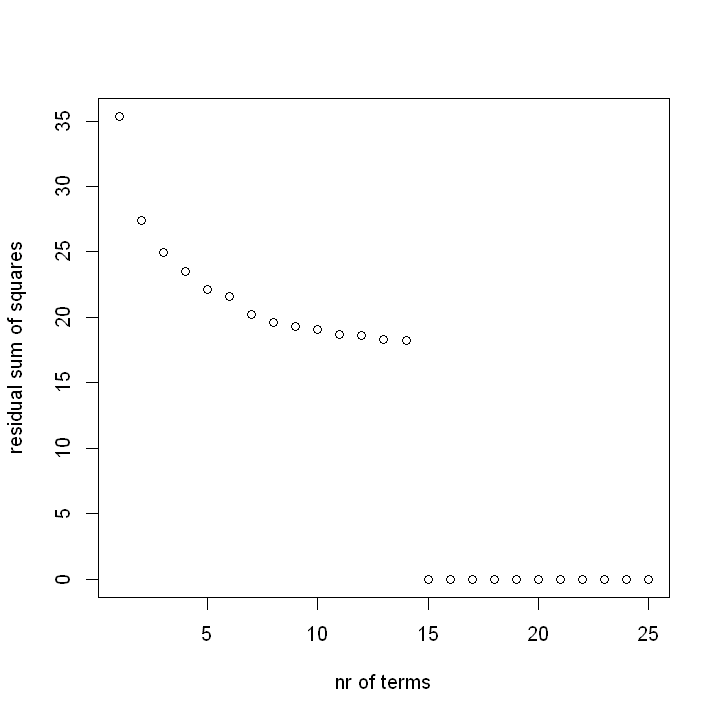

In [10]:
ppr_out = ppr(site_env_vars, site_RSpca_vars, nterms=1, max.terms=25, sm.method='supsmu', bass=2)
plot(ppr_out$gofn, ylab="residual sum of squares", xlab="nr of terms")

This curve usually typically exhibits a kind of kink (L-shaped curve) around some value, above which the sum of squares does not decrease much. This effect here seems to be more gradual, likely due to the amount of data points available (`n_sites`). We can also see that the curve drops to zero from $k$ = 15; this does not mean a perfect fit, but is more likely to results from numerical issues.

For illustration purpose, we will select the number of ridge terms $K$ to be 12. Fitting the PPR model to the HCAS data can then be achieved as follows:

In [11]:
ppr_out = ppr(site_env_vars, site_RSpca_vars, nterms=12, sm.method='supsmu', bass=2)

### Term loadings

For each term $k$, we can plot the term loadings for the ENV variables, i.e. the coefficients in the vector $\boldsymbol{\beta}_k$ used in the linear combinations of the ENV variables. For instance, for $k=1$, we have the following term loadings:

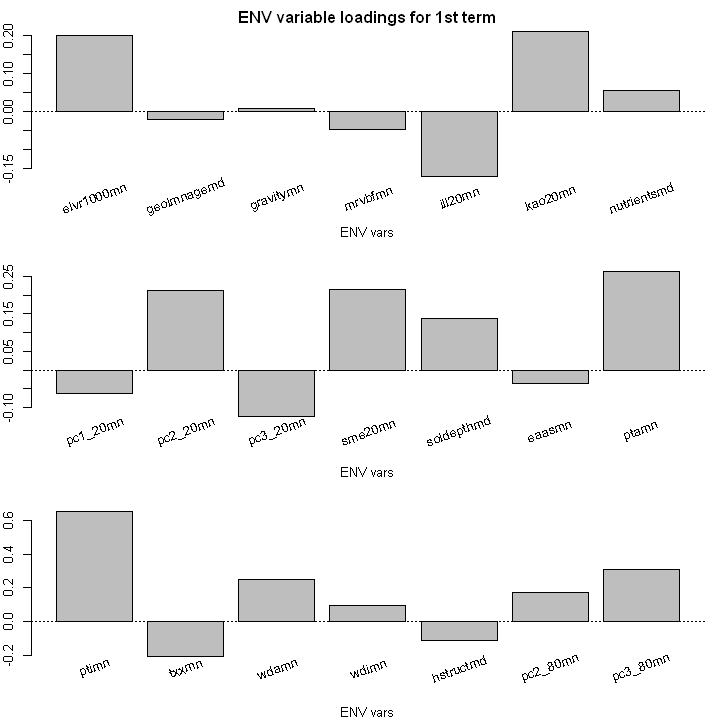

In [12]:
layout(matrix(1:3,ncol=1)); par(mar=c(4,2,2,1))
tmp = ppr_out$alpha[1:7,1]
x = barplot(tmp, ylab="", xaxt="n", xlab="ENV vars", main="ENV variable loadings for 1st term")
abline(h=0,lty=3)
text(cex=1, x=x, y=1.3*min(tmp), ppr_out$xnames[1:7], xpd=TRUE, srt=20)
tmp = ppr_out$alpha[8:14,1]
x = barplot(tmp, ylab="", xaxt="n", xlab="ENV vars")
abline(h=0,lty=3)
text(cex=1, x=x, y=1.3*min(tmp), ppr_out$xnames[8:14], xpd=TRUE, srt=20)
tmp = ppr_out$alpha[15:ppr_out$p,1]
x = barplot(tmp, ylab="", xaxt="n", xlab="ENV vars")
abline(h=0,lty=3)
text(cex=1, x=x, y=1.3*min(tmp), ppr_out$xnames[15:ppr_out$p], xpd=TRUE, srt=20)

These term loadings can be generated for each term $k=1...K$ and saved to file:

In [13]:
pdf('./HCAS_PPR_term_loadings.pdf')
layout(matrix(1:3,ncol=1))
for ( ii in 1:ppr_out$mu ) {
    tmp = ppr_out$alpha[1:7,ii]
    x = barplot(tmp, ylab="", xaxt="n", xlab="ENV vars", main=paste("ENV variable loadings for term",ii))
    abline(h=0,lty=3)
    text(cex=1, x=x, y=1.3*min(tmp), ppr_out$xnames[1:7], xpd=TRUE, srt=20)
    tmp = ppr_out$alpha[8:14,ii]
    x = barplot(tmp, ylab="", xaxt="n", xlab="ENV vars")
    abline(h=0,lty=3)
    text(cex=1, x=x, y=1.3*min(tmp), ppr_out$xnames[8:14], xpd=TRUE, srt=20)
    tmp = ppr_out$alpha[15:ppr_out$p,ii]
    x = barplot(tmp, ylab="", xaxt="n", xlab="ENV vars")
    abline(h=0,lty=3)
    text(cex=1, x=x, y=1.3*min(tmp), ppr_out$xnames[15:ppr_out$p], xpd=TRUE, srt=20)
}
tmp = dev.off()

These results appear to show that all ENV variables are involved with a significant term loading in at least one linear combination, indicating that all ENV variables are seemingly relevant to the model.

### Ridge functions

The next step is to look at the shape of the ridge functions $g_k(\cdot)$:

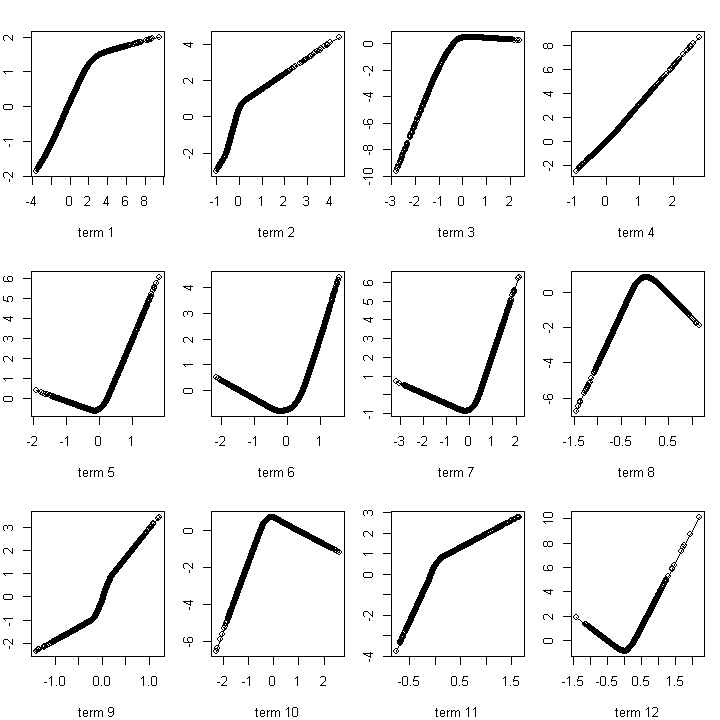

In [14]:
layout( matrix(1:12,nrow=3,byrow=T) )
par(mar=c(4,2,2,1))
plot(ppr_out)

Each of these plots represent the nonlinear transformation performed on the linear combination terms $\boldsymbol{\beta}_k^T \mathbf{x}$. THey can be used to check for evidence of possible over-fitting, in which case the `bass` parameter (which determines how smooth these functions are) can be fine-tuned.

Note that one drawback of the PPR approach is that its results are not readily interpretable. The ridge function are applied to _linear combinations_ of the ENV variables, and it is thus virtually impossible to derive physical understanding of what sort of transformation the ridge functions apply to the data.

### Actual vs. fitted values

The PPR method has basically determined the transformations to apply to the ENV variables so that the resulting (transformed) ENV variables best correlate with the RS variables. We can thus check the relationship between these PPR-transformed ENV variables and the RS PCA variables:

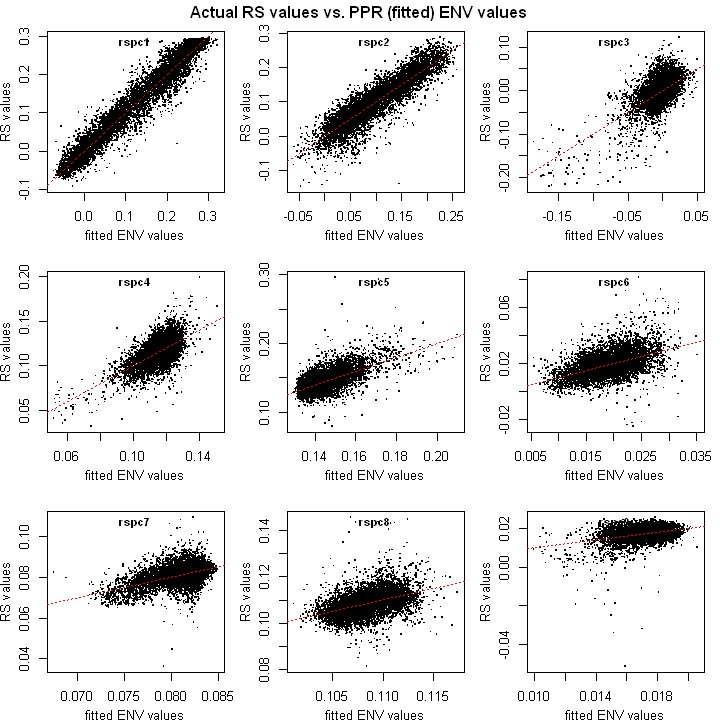

In [15]:
layout( matrix(1:9,nrow=3,byrow=T) )
par(mar=c(3,3,2,1))
for ( ii in 1:ppr_out$q ) {
    plot( ppr_out$fitted.values[,ii], site_RSpca_vars[,ii], ylab="", pch='.', cex=2, xlab="", main='')
    title(xlab="fitted ENV values", line=2.2)
    title(ylab="RS values", line=2.2)
    title(ppr_out$ynames[ii], line=-0.9, cex.main=0.8)
    abline(0,1,lty=3,col='red')
}
title("Actual RS values vs. PPR (fitted) ENV values", outer=TRUE, line=-1.1)

We can see that a good correlation results from PPR for most of the RS and fitted ENV variables. In contrast to GDM, the PPR model thus provides a relationship between the RS and ENV variables directly, which can subsequentlybe used to enable further improvements of the HCAS approach, e.g. by relating the change directions in both ENV and RS spaces (degradation pathways).

The residuals can also be investigated as a regression diagnostics to check for outliers and/or determine if there is any significant bias around the line at 0 (which would point to a poor model):

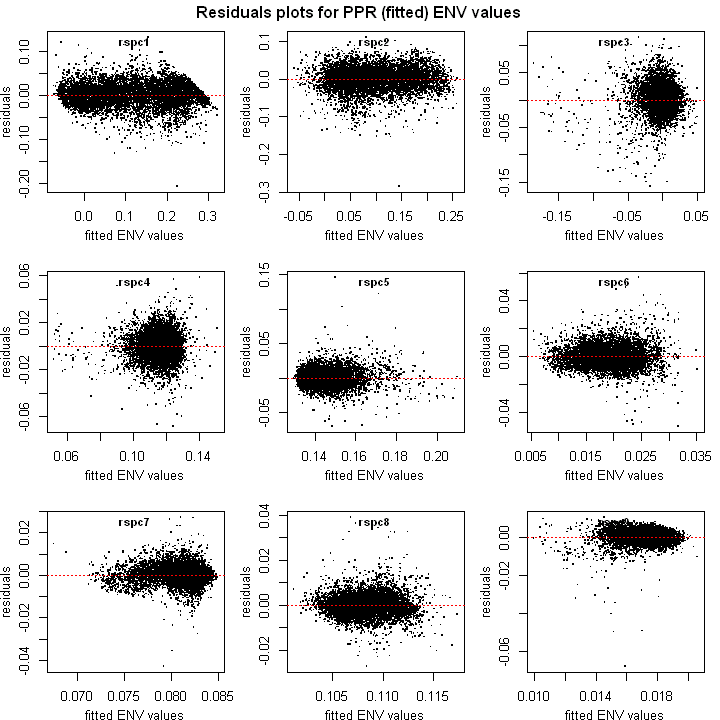

In [16]:
layout( matrix(1:9,nrow=3,byrow=T) )
par(mar=c(3,3,2,1))
for ( ii in 1:ppr_out$q ) {
    plot( ppr_out$fitted.values[,ii], ppr_out$residuals[,ii], ylab="", pch='.', cex=2, xlab="", main='')
    title(xlab="fitted ENV values", line=2.2)
    title(ylab="residuals", line=2.2)
    title(ppr_out$ynames[ii], line=-0.9, cex.main=0.8)
    abline(h=0,lty=3,col='red')
}
title("Residuals plots for PPR (fitted) ENV values", outer=TRUE, line=-1.1)

### RS distance vs. (transformed) ENV distance

As mentioned in the _'HCAS 3a(1) Methods Document'_, a crucial aspect of the current GDM approach is that it provides a correlation between the transformed ENV and the RS variables. This subsequently allows the prediction of RS distance (based on the known ENV distance) for a test site of interest whose condition has to be inferred.

It is thus important to also check the correlation among RS and ENV distances when using the PPR-fitted ENV variables. The RS distances (for each pair used in HCAS v1.0) have already been calculated offline for all pairs and saved to file. They can be loaded here as follows:

In [17]:
print( load('//OSM-09-cdc.it.csiro.au/OSM_CBR_DP_RSII_processing/Eric/HCAS/hcas_dist_RSpca9.Rdata') )
length(rsm_dist)   # about 1 million...

[1] "rsm_dist"


[1] 999972

The PPR-based ENV distances can be calculated as follows. 

In [18]:
site_PPRenv_vars = ppr_out$fitted.values
n_subs_pairs = length(p_subs_indx)
PPRenv_dist = rep(NA,n_subs_pairs)

for ( pp in 1:n_subs_pairs ) {
    ind1 = which( subs_indx==pind_data[p_subs_indx[pp],1] )
    ind2 = which( subs_indx==pind_data[p_subs_indx[pp],2] )
    env1 = site_PPRenv_vars[ind1,] 
    env2 = site_PPRenv_vars[ind2,] 
    PPRenv_dist[pp] = sum(abs(env1-env2), na.rm=TRUE)    # Manhattan distance
}

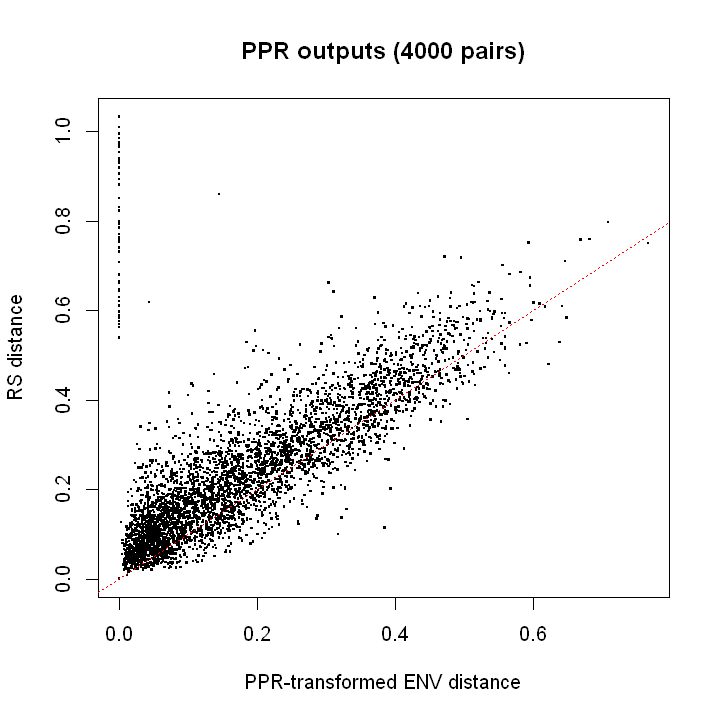

In [19]:
rsm_dist = rsm_dist[p_subs_indx]   # select desired pairs subset from rsm_dist

plot(PPRenv_dist, rsm_dist, pch='.', cex=2, xlab='', ylab='', main='')
title(xlab="PPR-transformed ENV distance", ylab="RS distance", 
      main=paste("PPR outputs (",length(rsm_dist)," pairs)",sep=''))
abline(0,1,lty=3,col='red')

Some issues remain to be sorted out, as indicated by the array of pairs with 0 PPR-transformed ENV distance. This will need investigating, but is likely due to a code error resulting from the omission of sites with 0 RS PCA values and non-matching indices with the selected sites / pairs subset.

The above procedure has been applied offline to the entire HCAS dataset of approx. 425,000 sites (~1m pairs). The current results (which likely include the above mentioned code bug) are presented below on the basis of results saved to file.

In [20]:
print( load('//OSM-09-cdc.it.csiro.au/OSM_CBR_DP_RSII_processing/Eric/HCAS/hcas_eda05_PPR_subs1_scaledENV_supsmu_bass1_dist.Rdata') )
print( load('//OSM-09-cdc.it.csiro.au/OSM_CBR_DP_RSII_processing/Eric/HCAS/hcas_eda05_PPR_subs1_scaledENV_supsmu_bass1_ppr.Rdata') )

[1] "PPRenv_dist" "rsm_dist"   
[1] "ppr_out"


First, let's display the relationships among the RS and PPR-transformed ENV variables (using all available sites).

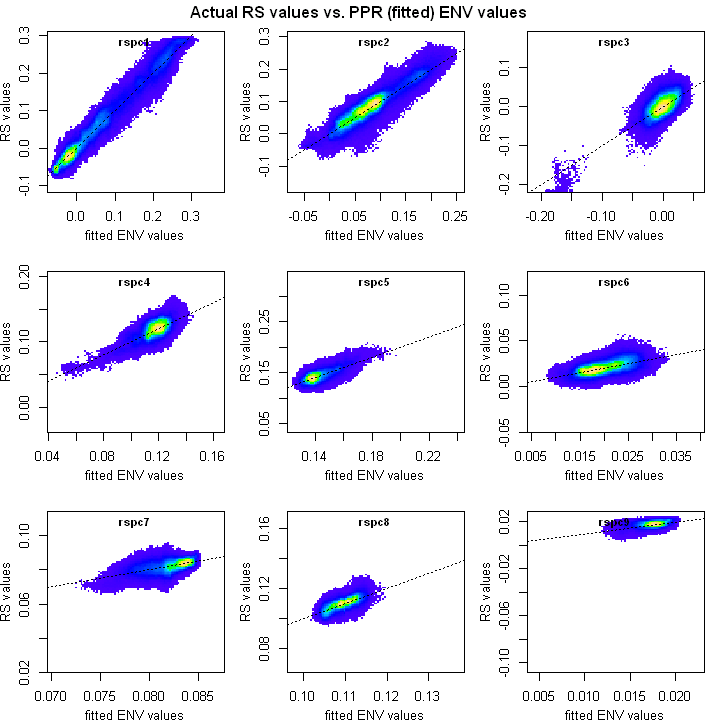

In [21]:
# we actually have to re-load variable 'site_RSpca_vars' here to match the results saved to file...
load("//OSM-09-cdc.it.csiro.au/OSM_CBR_DP_RSII_processing/Eric/HCAS/HCAS_vars.Rdata")
tmp = which( rowSums(abs(site_RSpca_vars))==0 )
site_RSpca_vars = site_RSpca_vars[-tmp,1:9] / 4

layout( matrix(1:9,nrow=3,byrow=T) ); par(mar=c(3,3,2,1))
for ( ii in 1:ppr_out$q ) {
    tmp = hist2d(ppr_out$fitted.values[,ii], site_RSpca_vars[,ii], nbins=c(n_bins,n_bins), col=cmap)
    box()
    title(xlab="fitted ENV values", line=2.2)
    title(ylab="RS values", line=2.2)
    title(ppr_out$ynames[ii], line=-0.9, cex.main=0.8)
    abline(0,1,lty=3)
}
title("Actual RS values vs. PPR (fitted) ENV values", outer=TRUE, line=-1.1)

And now the RS distances vs. PPR-based ENV distances (based on all available pairs).

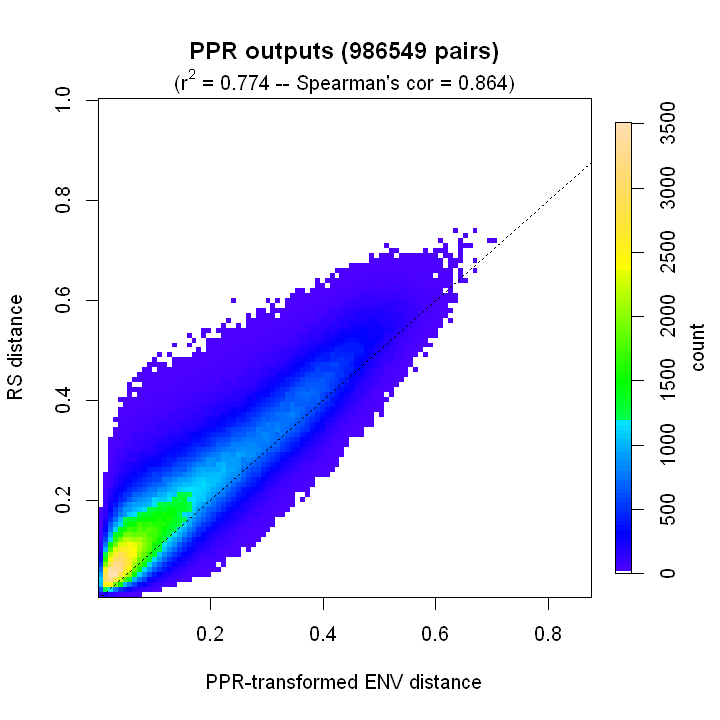

In [22]:
layout(matrix(c(1,2),nrow=1), widths=c(10,1.7)); par(mar=c(5.1,4.1,4.1,1))
tmp = hist2d(PPRenv_dist, rsm_dist, nbins=c(n_bins,n_bins), col=cmap); box()
title( xlab="PPR-transformed ENV distance", ylab="RS distance", 
       main=paste("PPR outputs (",length(rsm_dist)," pairs)",sep='') )
abline(0,1,lty=3)
lmout = lm(rsm_dist~PPRenv_dist)
r2 = round(summary(lmout)$r.squared,3)
cc = round(cor(rsm_dist,PPRenv_dist,method='spearman'),3)
title( main=bquote(paste('(',r^2,' = ',.(r2)," -- Spearman's cor = ",.(cc),')',sep='')), 
       line=0.75, font.main=1, cex.main=1 )
cbar(0, max(tmp$count,na.rm=T), color_pal=cmap, 'count')